# Sentiment Analysis on Student Feedback in Engineering Education

## Introduction

In the field of engineering education, student feedback plays a vital role in assessing the effectiveness of teaching methods, course materials, and overall learning experiences. Sentiment analysis, a key component of data science, offers a powerful approach to analyze and extract valuable insights from student feedback. <br> <br>
The objective of this project is to perform sentiment analysis on the feedback provided by computer engineering students. By leveraging natural language processing (NLP) techniques and machine learning algorithms, we aim to uncover sentiments expressed in the feedback and gain a comprehensive understanding of student perceptions, satisfaction, and areas of improvement. <br> <br>
Through the analysis of student feedback, we can identify common themes, sentiment trends, and specific challenges faced by students. This valuable information can help inform the department and it's lectureres about the effectiveness of their teaching methodologies, course content, and student support systems. The insights derived from sentiment analysis on student feedback can drive evidence-based decision-making in engineering education. It enables the department to address concerns, make improvements, and create a positive learning environment that caters to the needs of their students.

## Data Collection
To get the data to use for this project, I utilized [Google Forms](https://docs.google.com/forms/d/e/1FAIpQLSeInhWFxECdegDDIYo7uY3-U-JHYyUDkTBQBw-KJxIvzYg_yA/viewform) to collect valuable feedback from students. The platform facilitated the collection of diverse responses, streamlined data collection, ensuring accuracy and efficiency in gathering student sentiments and  provided a comprehensive dataset for the sentiment analysis.

In [129]:
# import libraries and packages

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white')

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# Load the spaCy English model
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load the dataset and show first 5 rows
df = pd.read_csv('Sentiment Analysis on Student Feedback.csv')
df.head()

,Timestamp,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Unnamed: 10
0,2023/05/21 3:29:49 AM MDT,CPE 321,"The man is too fast in his teaching,he clearly...",No,Male,Regular,Challenging,21 hours,5,Yes,20/30GR072
1,2023/05/21 3:39:59 AM MDT,CPE 331,The class is dry but he really puts in efforts,Yes,Male,Regular,Moderate,7,8,Yes,19/30GR010
2,2023/05/21 3:57:54 AM MDT,CPE 321,The course is shit and it's a threat to my bra...,No,Male,Regular,Challenging,7hrs,4,Yes,20/30GR073
3,2023/05/21 4:52:08 AM MDT,CPE 321,"He no try at all, didn’t teach well.",No,Male,Regular,Challenging,12,1,Yes,NaN
4,2023/05/21 5:24:33 AM MDT,CPE 321,Ogbeni you sef know as e dae go,Yes,Male,Occasional,Difficult,How you want take study something wey you head...,0,Yes,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Timestamp               28 non-null     object
 1   Course Code             28 non-null     object
 2   Feedback                28 non-null     object
 3   Previous Experience     28 non-null     object
 4   Gender                  28 non-null     object
 5   Attendance              28 non-null     object
 6   Course Difficulty       28 non-null     object
 7   Study Hours (per week)  28 non-null     object
 8   Overall Satisfaction    28 non-null     int64 
 9   Department              28 non-null     object
 10  Unnamed: 10             3 non-null      object
dtypes: int64(1), object(10)
memory usage: 2.5+ KB


## Data Cleaning
Here, I'm going to clean the dataset as it can be seen to have some quality issues.

In [5]:
df.columns

Index(['Timestamp', 'Course Code', 'Feedback ', 'Previous Experience ',
       'Gender', 'Attendance', 'Course Difficulty ', 'Study Hours (per week)',
       'Overall Satisfaction ', 'Department ', 'Unnamed: 10'],
      dtype='object')

In [6]:
df.columns = df.columns.str.strip()
print(df.columns)

Index(['Timestamp', 'Course Code', 'Feedback', 'Previous Experience', 'Gender',
       'Attendance', 'Course Difficulty', 'Study Hours (per week)',
       'Overall Satisfaction', 'Department', 'Unnamed: 10'],
      dtype='object')


In [7]:
# drop unncessary column
df = df.drop(['Unnamed: 10'], axis=1)

# Convert the column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract the date and time into separate columns
df['Date'] = df['Timestamp'].dt.date
df['Time'] = df['Timestamp'].dt.time

# drop Timestamp column
df = df.drop(['Timestamp'], axis=1)

# corrections to "Study Hours (per week) column"
df['Study Hours (per week)'] = df['Study Hours (per week)'].str.extract(r'(\d+)').fillna(0).astype(int)

# replace 'LGBTQ 😂' with 'Male'
df['Gender'] = df['Gender'].replace('LGBTQ 😂', 'Male')

In [8]:
# overview of the data again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Course Code             28 non-null     object
 1   Feedback                28 non-null     object
 2   Previous Experience     28 non-null     object
 3   Gender                  28 non-null     object
 4   Attendance              28 non-null     object
 5   Course Difficulty       28 non-null     object
 6   Study Hours (per week)  28 non-null     int32 
 7   Overall Satisfaction    28 non-null     int64 
 8   Department              28 non-null     object
 9   Date                    28 non-null     object
 10  Time                    28 non-null     object
dtypes: int32(1), int64(1), object(9)
memory usage: 2.4+ KB


In [10]:
# preview random sample of the data
df.sample(5)

,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Date,Time
1,CPE 331,The class is dry but he really puts in efforts,Yes,Male,Regular,Moderate,7,8,Yes,2023-05-21,03:39:59
8,MEE 361,The teaching mode is okay as the lecturer do r...,No,Male,Regular,Moderate,4,8,Yes,2023-05-21,08:48:19
23,CPE 321,Awful,No,Male,Regular,Difficult,4,2,Yes,2023-05-24,09:48:15
20,MEE 361,This lecturer really tried for us to be honest...,Yes,Male,Regular,Moderate,12,7,Yes,2023-05-24,09:35:13
26,CPE 381,"The lecturer is good, I like him.",No,Female,Regular,Moderate,2,8,Yes,2023-05-26,14:43:35


## Data Preprocessing
Cleaning and preprocessing the data by removing stop words, punctuations, and special characters.

preprocess the feedback column

In [11]:
# Function to handle contractions
def handle_contractions(text):
    contractions = {
        "n't": " not",
        "'s": " is",
        "'re": " are",
        "'ve": " have",
        "'d": " would",
        "'ll": " will",
        "'m": " am"
    }

    words = text.split()
    for i in range(len(words)):
        if words[i] in contractions:
            words[i] = contractions[words[i]]
    return ' '.join(words)

# Function to preprocess text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Handle contractions
    text = handle_contractions(' '.join(tokens))

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text)]

    # Join tokens back into a single string
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to the 'Feedback' column
df['Processed_Feedback'] = df['Feedback'].apply(preprocess_text)

In [16]:
# lets check out the column
df['Processed_Feedback'][:10].to_frame()

,Processed_Feedback
0,man fast teachinghe clearly doesnt know teach ...
1,class dry really put effort
2,course shit threat brainthe teaching mode poor
3,try ’ teach well
4,ogbeni sef know e dae go
5,omo god judge ak sha ’ take class like expect ...
6,man good
7,e choke
8,teaching mode okay lecturer revision whats tau...
9,basically experience cpe ’ hard method employe...


calaculating the sentiment scores and it's corresponding labels

In [17]:
# Calculate sentiment scores
df['Sentiment_Score'] = df['Processed_Feedback'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Map sentiment scores to sentiment labels
df['Sentiment_Label'] = df['Sentiment_Score'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

In [18]:
# lets checkout some random samples of the data
df.sample(5)

,Course Code,Feedback,Previous Experience,Gender,Attendance,Course Difficulty,Study Hours (per week),Overall Satisfaction,Department,Date,Time,Processed_Feedback,Sentiment_Score,Sentiment_Label
13,CPE 321,The course isn’t supposed to be this difficult...,Yes,Male,Regular,Challenging,0,2,Yes,2023-05-22,02:42:44,course ’ supposed difficult lecturer taken tim...,-0.50,Negative
0,CPE 321,"The man is too fast in his teaching,he clearly...",No,Male,Regular,Challenging,21,5,Yes,2023-05-21,03:29:49,man fast teachinghe clearly doesnt know teach ...,0.15,Positive
2,CPE 321,The course is shit and it's a threat to my bra...,No,Male,Regular,Challenging,7,4,Yes,2023-05-21,03:57:54,course shit threat brainthe teaching mode poor,-0.30,Negative
18,CPE 341,"The course is not well taught. Worst still, we...",Yes,Male,Regular,Moderate,10,6,Yes,2023-05-24,09:31:08,course well taught worst still writing code pa...,-1.00,Negative
8,MEE 361,The teaching mode is okay as the lecturer do r...,No,Male,Regular,Moderate,4,8,Yes,2023-05-21,08:48:19,teaching mode okay lecturer revision whats tau...,0.50,Positive


## Aspect-Based sentiment Analysis Metrics

### Summary statistics and metrics 

In [151]:
# Sentiment Analysis Metrics
sentiment_counts = df['Sentiment'].value_counts()
average_sentiment_score = df['Sentiment_Score'].mean()

# Descriptive Statistics
study_hours_stats = df['Study Hours (per week)'].describe()
overall_satisfaction_stats = df['Overall Satisfaction'].describe()

# Categorical Metrics
course_code_counts = df['Course Code'].value_counts()
department_counts = df['Department'].value_counts()
sentiment_distribution = df.groupby('Course Code')['Sentiment'].value_counts(normalize=True)

# Print the calculated metrics
print("Sentiment Analysis Metrics:")
print(sentiment_counts)
print("Average Sentiment Score:", average_sentiment_score)
print("\nDescriptive Statistics - Study Hours:")
print(study_hours_stats)
print("\nDescriptive Statistics - Overall Satisfaction:")
print(overall_satisfaction_stats)
print("\nCategorical Metrics - Course Code Counts:")
print(course_code_counts)
print("\nCategorical Metrics - Department Counts:")
print(department_counts)
print("\nSentiment Distribution by Course Code:")
print(sentiment_distribution)

Sentiment Analysis Metrics:
Negative    17
Positive     6
Neutral      5
Name: Sentiment, dtype: int64
Average Sentiment Score: -0.05694444444444442

Descriptive Statistics - Study Hours:
count    28.000000
mean      5.678571
std       4.884242
min       0.000000
25%       2.000000
50%       4.500000
75%       9.000000
max      21.000000
Name: Study Hours (per week), dtype: float64

Descriptive Statistics - Overall Satisfaction:
count    28.000000
mean      3.642857
std       3.081778
min       0.000000
25%       1.000000
50%       3.000000
75%       6.250000
max      10.000000
Name: Overall Satisfaction, dtype: float64

Categorical Metrics - Course Code Counts:
CPE 321    18
CPE 331     2
MEE 361     2
CPE 341     2
CPE 381     2
CPE 311     1
GSE 301     1
Name: Course Code, dtype: int64

Categorical Metrics - Department Counts:
Yes    27
No      1
Name: Department, dtype: int64

Sentiment Distribution by Course Code:
Course Code  Sentiment
CPE 311      Positive     1.000000
CPE 321 

### Analyze the frequency of specific keywords or phrases in the feedback

In [25]:
# analyze the frequency of specific keywords or phrases in the feedback
from collections import Counter

# The keywords or phrases of interest
keywords = ['shit', 'difficult', 'terrible', 'okay', 'best', 'worst', 'good']

# Concatenate all the preprocessed feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

# Tokenize the text into individual words
tokens = all_feedback.split()

# Count the frequency of each keyword in the feedback
keyword_frequency = Counter(tokens)

# Print the frequency of each keyword
for keyword in keywords:
    print(f"Frequency of '{keyword}': {keyword_frequency[keyword]}")


Frequency of 'shit': 1
Frequency of 'difficult': 2
Frequency of 'terrible': 2
Frequency of 'okay': 1
Frequency of 'best': 1
Frequency of 'worst': 2
Frequency of 'good': 2


### Text clustering to group similar feedback together

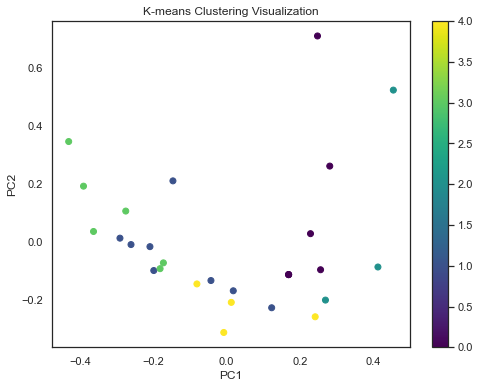

Top terms per cluster:
Cluster 0:
  like
  god
  awful
  choke
  cap
  say
  omooooo
  good
  dont
  period

Cluster 1:
  time
  lecturer
  taught
  class
  course
  worst
  difficult
  interactive
  little
  learn

Cluster 2:
  man
  teach
  well
  good
  try
  clearly
  fast
  teachinghe
  doesnt
  know

Cluster 3:
  teaching
  course
  method
  lecturer
  terrible
  understand
  bit
  need
  practical
  application

Cluster 4:
  go
  left
  study
  really
  basically
  course
  sef
  dae
  ogbeni
  student



In [130]:
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Apply TF-IDF vectorization to the processed feedback text
tfidf_matrix = vectorizer.fit_transform(df['Processed_Feedback'])

# Perform K-means clustering
num_clusters = 5  # Specify the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Assign cluster labels to the feedback data
df['Cluster'] = kmeans.labels_

# Apply dimensionality reduction using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['Cluster'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering Visualization')
plt.colorbar()
plt.show()

# Print the top terms for each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f"  {terms[ind]}")
    print()

### Feature Engineering

In [127]:
df['Word_Count'] = df['Processed_Feedback'].apply(lambda x: len(x.split()))
df['Char_Count'] = df['Processed_Feedback'].apply(len)

sid = SentimentIntensityAnalyzer()
df['Positive_Score'] = df['Processed_Feedback'].apply(lambda x: sid.polarity_scores(x)['pos'])
df['Negative_Score'] = df['Processed_Feedback'].apply(lambda x: sid.polarity_scores(x)['neg'])
df['Neutral_Score'] = df['Processed_Feedback'].apply(lambda x: sid.polarity_scores(x)['neu'])

## Topic Modeling
Implementing topic modeling techniques such as Latent Dirichlet Allocation (LDA) or Non-negative Matrix Factorization (NMF) to identify underlying topics or themes in the feedback data. This can provide deeper insights into the content and help analyze sentiment within specific topics.

In [97]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create a CountVectorizer
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(1, 2))

# Apply CountVectorizer to the processed feedback text
dtm = vectorizer.fit_transform(df['Processed_Feedback'])

# Perform LDA topic modeling
num_topics = 7  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
feature_names = vectorizer.get_feature_names()
top_words = 10  # Specify the number of top words to retrieve for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

Topic 0:
teaching lecturer time student like teaching mode mode good course really

Topic 1:
lecturer worst terrible student far basically study left left study fucking

Topic 2:
course lecturer time god taught make sha explained difficult lecturer difficult

Topic 3:
course bit understand teaching really material teaching course bit rushed felt course term

Topic 4:
know man teach student fast clearly teach student teachinghe teachinghe clearly doesnt know

Topic 5:
choke awful say omooooo say omooooo man man good little time little time learn

Topic 6:
lecturer class class interactive interactive make material time actually method teaching method



## Emotion Detection
Identifying emotions in student feedback. The sentiment property of the TextBlob object to retrieve the sentiment scores which includes polarity (a value between -1 and 1 indicating the sentiment) and subjectivity (a value between 0 and 1 indicating the subjectivity of the text). <br>
**Emotion Polarity**: Emotion polarity measures the sentiment or emotional tone of a text. It indicates whether the text expresses a positive, negative, or neutral emotion. In the code provided, the polarity scores are obtained using the SentimentIntensityAnalyzer from NLTK. The polarity scores include values for positive, negative, and neutral sentiment. The sentiment polarity can help identify the overall sentiment or emotional tone of the feedback text. <br>
**Emotion Subjectivity**: Emotion subjectivity measures the degree of subjectivity or objectivity in the expression of emotions in a text. It indicates how much the text relies on personal opinions, beliefs, or experiences rather than factual or objective information. A higher subjectivity score suggests that the text is more influenced by personal perspectives or experiences.

In [128]:
def calculate_emotions(text):
    blob = TextBlob(text)
    emotion_scores = blob.sentiment.polarity, blob.sentiment.subjectivity
    return emotion_scores

# Apply emotion analysis to the feedback text
df['Emotion_Scores'] = df['Processed_Feedback'].apply(calculate_emotions)

# Extract emotion scores for each emotion category
df['Emotion_Polarity'] = df['Emotion_Scores'].apply(lambda x: x[0])
df['Emotion_Subjectivity'] = df['Emotion_Scores'].apply(lambda x: x[1])

# assign emotion labels based on polarity values
df['Emotion_Label'] = df['Emotion_Polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

# the resulting dataframe with emotion scores and labels
df[['Processed_Feedback', 'Emotion_Polarity', 'Emotion_Subjectivity', 'Emotion_Label']].head()

,Processed_Feedback,Emotion_Polarity,Emotion_Subjectivity,Emotion_Label
0,man fast teachinghe clearly doesnt know teach ...,0.150000,0.491667,Positive
1,class dry really put effort,0.066667,0.400000,Positive
2,course shit threat brainthe teaching mode poor,-0.300000,0.700000,Negative
3,try ’ teach well,0.000000,0.000000,Neutral
4,ogbeni sef know e dae go,0.000000,0.000000,Neutral


## Sentiment Data Visualization
Creating meaningful visualizations to gain insights and communicate findings effectively. Exploring different types of plots, charts, and graphs to showcase various aspects of the data and also analyzing the distribution of sentiment labels in the data to understand the overall sentiment polarity.

### Correlation Analysis
Exploring the correlation between sentiment and other variables in the dataset to identify potential relationships.

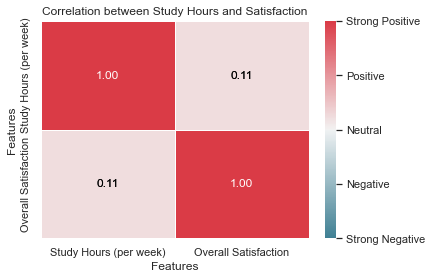

In [32]:
correlation_matrix = df[['Study Hours (per week)', 'Overall Satisfaction']].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Study Hours and Satisfaction')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

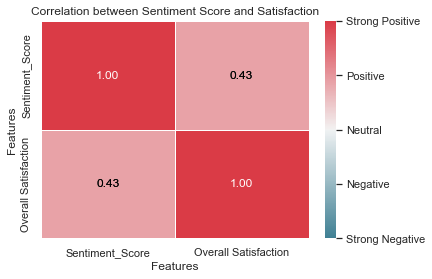

In [34]:
correlation_matrix = df[['Sentiment_Score', 'Overall Satisfaction']].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between Sentiment Score and Satisfaction')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

### Univariate Exploration

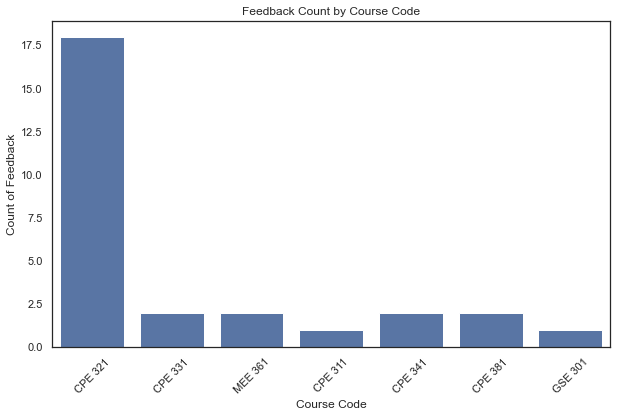

In [40]:
# Bar plot for Course Code
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.countplot(data=df, x='Course Code', color=color)
plt.xlabel('Course Code')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Code')
plt.xticks(rotation=45)
plt.show()

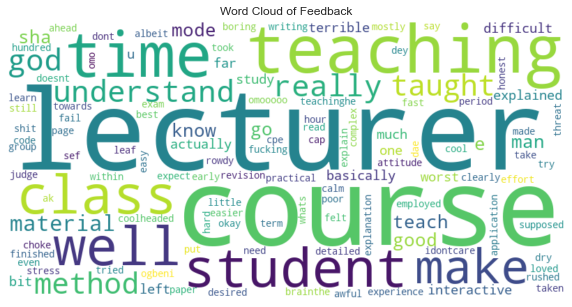

In [38]:
# Word cloud for Feedback
from wordcloud import WordCloud

# Combine all feedback into a single string
all_feedback = ' '.join(df['Processed_Feedback'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_feedback)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Feedback')
plt.show()

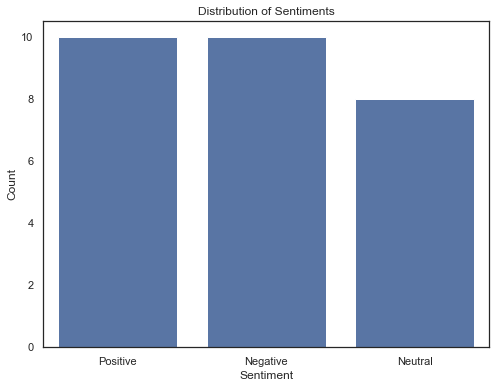

In [41]:
# Bar plot for Sentiment
plt.figure(figsize=(8, 6))
color = sns.color_palette()[0]
order = df['Sentiment_Label'].value_counts().index
sns.countplot(data=df, x='Sentiment_Label', color=color, order=order)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.show()

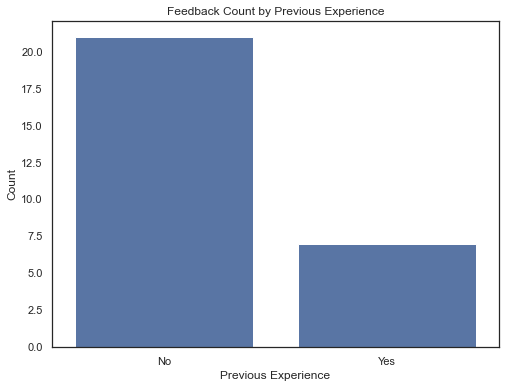

In [48]:
# Bar plot for Previous Experience
plt.figure(figsize=(8, 6))
color = sns.color_palette()[0]
sns.countplot(data=df, x='Previous Experience', color=color)
plt.xlabel('Previous Experience')
plt.ylabel('Count')
plt.title('Feedback Count by Previous Experience')
plt.show()

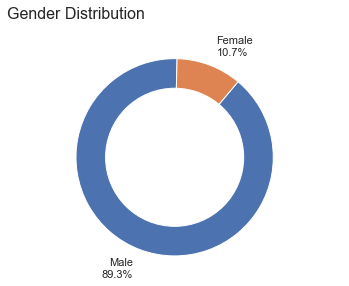

In [46]:
# Pie chart for Gender
counts = df['Gender'].value_counts()
fig, ax = plt.subplots()
# colors = ['#8e0201', '#e8cccc']
label = ['Male\n89.3%', 'Female\n10.7%']
ax.pie(counts, labels=label, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Gender Distribution', fontsize = 16, loc='left', pad=30)
ax.axis('equal')
plt.show()

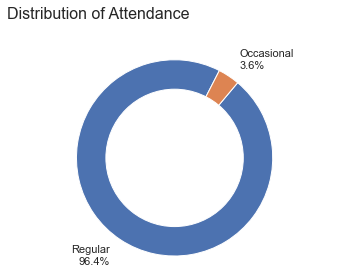

In [47]:
# Pie chart for Attendance
counts = df['Attendance'].value_counts()
fig, ax = plt.subplots()
label = ['Regular\n96.4%', 'Occasional\n3.6%']
ax.pie(counts, labels=label, startangle=50, counterclock=False, pctdistance=0.8, labeldistance=1.2)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
ax.set_title('Distribution of Attendance', fontsize = 16, loc='left', pad=30)
ax.axis('equal')
plt.show()

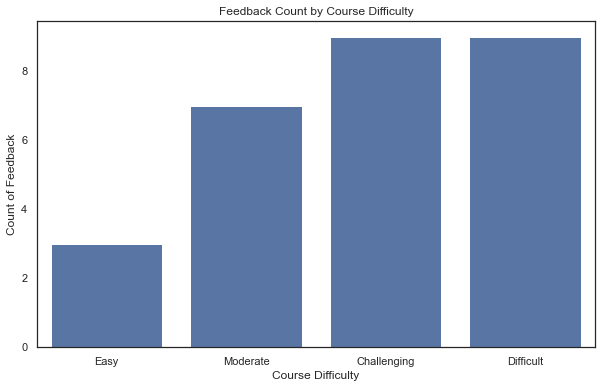

In [173]:
# Bar plot for Course Difficulty
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.countplot(data=df, x='Course Difficulty', color=color, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Difficulty')
plt.show();

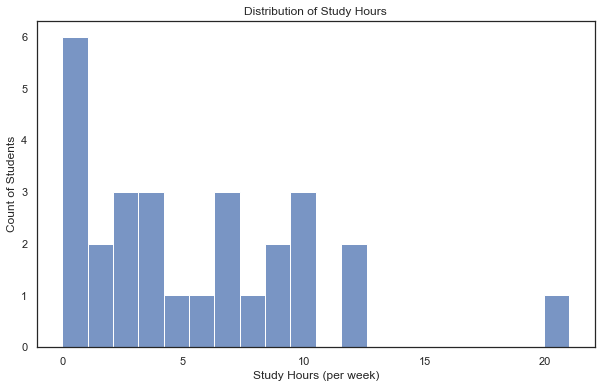

In [59]:
# Histogram for Study Hours (per week)
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.histplot(data=df, x='Study Hours (per week)', bins=20, color=color)
plt.xlabel('Study Hours (per week)')
plt.ylabel('Count of Students')
plt.title('Distribution of Study Hours')
plt.show()

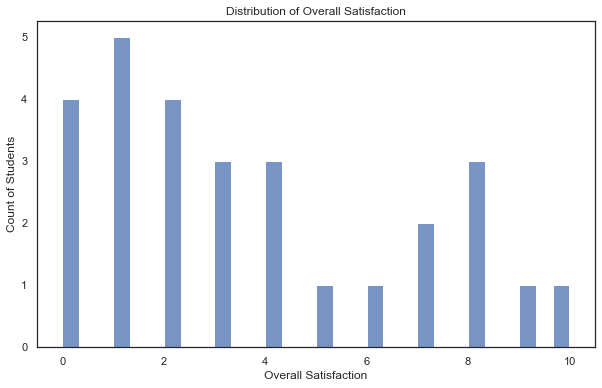

In [63]:
# Histogram for Overall Satisfaction
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Overall Satisfaction', bins=30)
plt.xlabel('Overall Satisfaction')
plt.ylabel('Count of Students')
plt.title('Distribution of Overall Satisfaction')
plt.show()

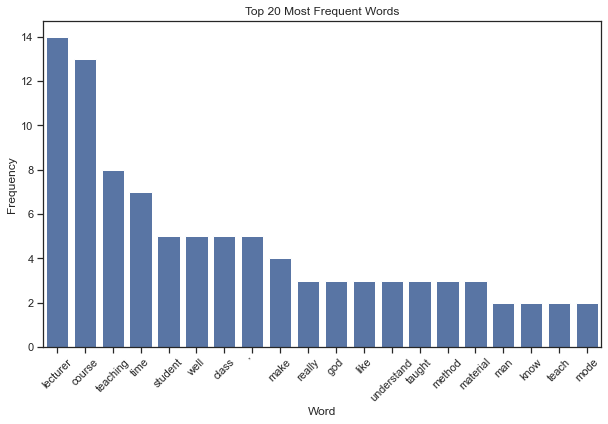

In [264]:
# Word Frequency Analysis
from collections import Counter
word_frequency = Counter(" ".join(df['Processed_Feedback']).split()).most_common(20)
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.barplot(x=[word[0] for word in word_frequency], y=[word[1] for word in word_frequency], color=color)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

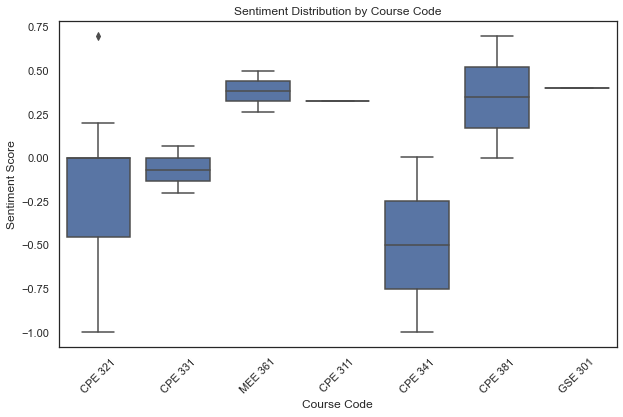

In [94]:
# Sentiment Box Plots
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.boxplot(data=df, x='Course Code', y='Sentiment_Score', color=color)
plt.xlabel('Course Code')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Distribution by Course Code')
plt.xticks(rotation=45)
plt.show()

### Bivariate Exploration

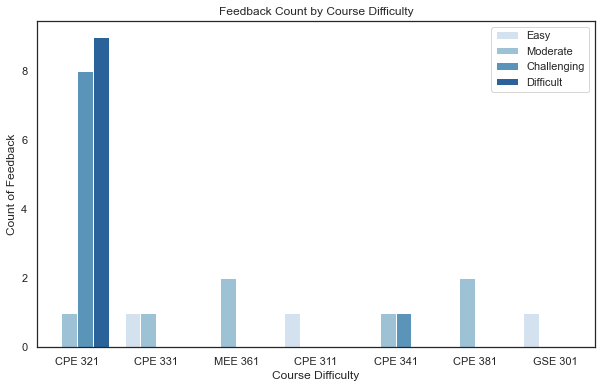

In [201]:
# Bar plot for Course Difficulty
plt.figure(figsize=(10, 6))
hue_order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
sns.countplot(data=df, x='Course Code', hue='Course Difficulty', palette='Blues', hue_order=hue_order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Feedback Count by Course Difficulty')
plt.legend(loc=1)
plt.show();

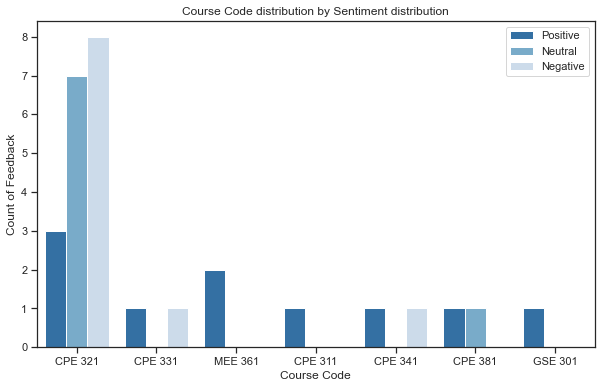

In [265]:
# Bar plot for Course Code distribution by Sentiment distribution
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
sns.countplot(data=df, x='Course Code', hue='Sentiment_Label', palette='Blues_r', hue_order=hue_order)
plt.xlabel('Course Code')
plt.ylabel('Count of Feedback')
plt.title('Course Code distribution by Sentiment distribution')
plt.legend(loc=1)
plt.show();

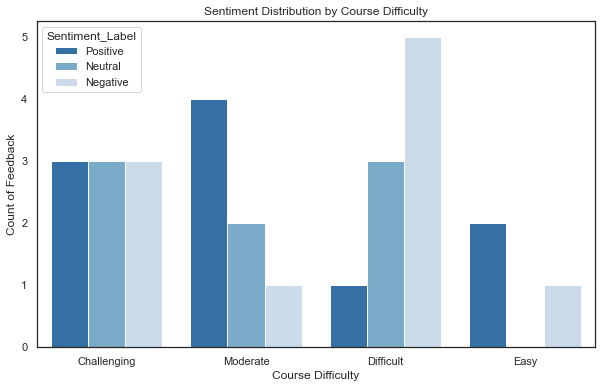

In [206]:
# Sentiment Distribution by Course Difficulty
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
sns.countplot(data=df, x='Course Difficulty', hue='Sentiment_Label', palette='Blues_r', hue_order=hue_order)
plt.xlabel('Course Difficulty')
plt.ylabel('Count of Feedback')
plt.title('Sentiment Distribution by Course Difficulty')
plt.show()

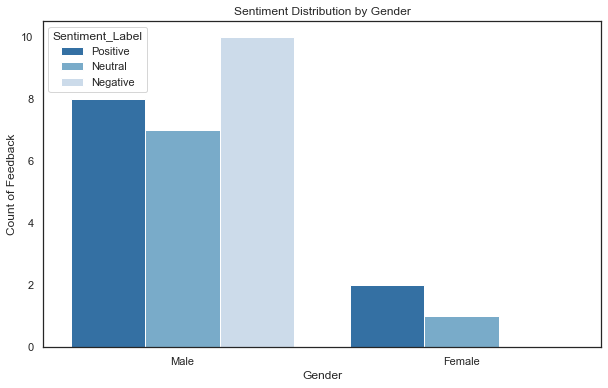

In [210]:
# Sentiment Distribution by Gender
plt.figure(figsize=(10, 6))
hue_order = ['Positive', 'Neutral', 'Negative']
sns.countplot(data=df, x='Gender', hue='Sentiment_Label', hue_order=hue_order, palette='Blues_r')
plt.xlabel('Gender')
plt.ylabel('Count of Feedback')
plt.title('Sentiment Distribution by Gender')
plt.show()

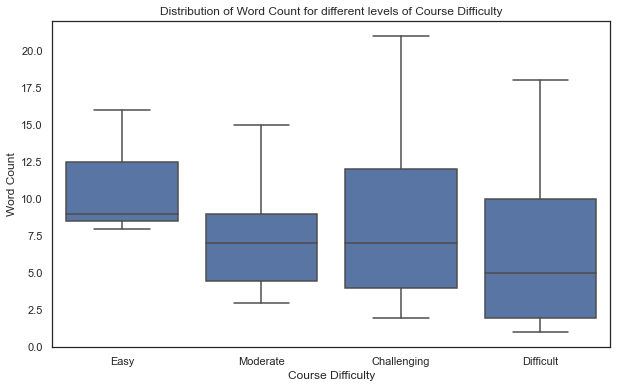

In [220]:
# Word Count distribution by course difficulty
plt.figure(figsize=(10, 6))
order = ['Easy', 'Moderate', 'Challenging', 'Difficult']
color = sns.color_palette()[0]
sns.boxplot(data=df, x='Course Difficulty', y='Word_Count', color=color, order=order)
plt.xlabel('Course Difficulty')
plt.ylabel('Word Count')
plt.title('Distribution of Word Count for different levels of Course Difficulty')
plt.show()

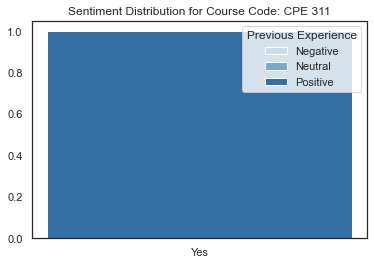

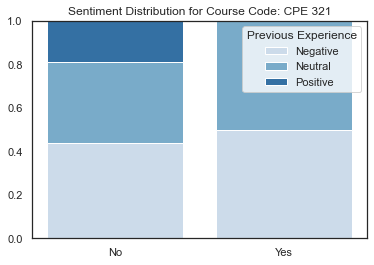

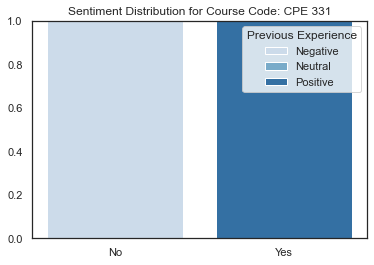

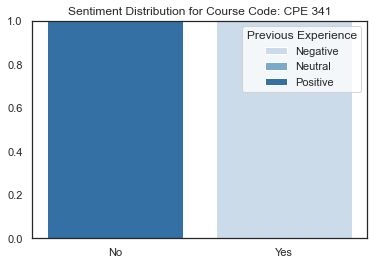

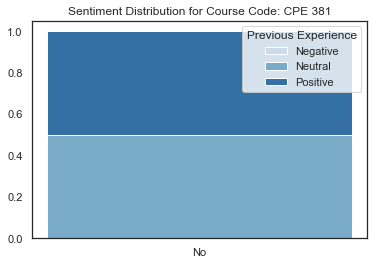

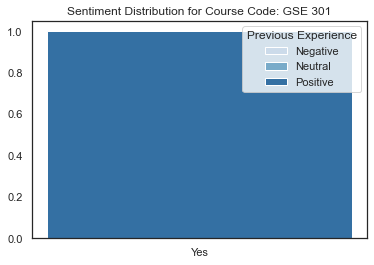

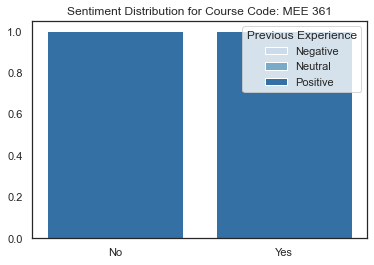

In [230]:
# Distribution of sentiment labels for different "Previous Experience" categories across various "Course Code" categories
subset_df = df[['Course Code', 'Previous Experience', 'Sentiment_Label']]

# Group the data by 'Course Code', 'Previous Experience', and 'Sentiment_Label' and count the occurrences
grouped_df = subset_df.groupby(['Course Code', 'Previous Experience', 'Sentiment_Label']).size().unstack(fill_value=0)

# Set the sentiment labels and their corresponding colors
sentiment_labels = ['Negative', 'Neutral', 'Positive']
colors = ['#CCDBEA', '#79ABC9', '#3470A3']

# Initialize the plot
fig, ax = plt.subplots()

# Loop through each 'Course Code' category
for i, course_code in enumerate(grouped_df.index.get_level_values('Course Code').unique()):
    # Get the data for the current 'Course Code'
    course_data = grouped_df.loc[course_code]
    
    # Calculate the relative frequency for each sentiment label
    total_counts = course_data.sum(axis=1)
    relative_freq = course_data.div(total_counts, axis=0)
    
    # Plot the stacked bar chart for each 'Previous Experience' category
    x = np.arange(len(course_data.index))
    bottom = np.zeros(len(course_data.index))
    for j, prev_exp in enumerate(relative_freq.columns):
        plt.bar(x, relative_freq[prev_exp], bottom=bottom, color=colors[j], label=prev_exp)
        bottom += relative_freq[prev_exp]
    
    # Adjust the x-axis labels
    plt.xticks(x, course_data.index)
    
    # Add a legend and set the title
    plt.legend(title='Previous Experience')
    plt.title(f'Sentiment Distribution for Course Code: {course_code}')
    
    # Show the plot
    plt.show()

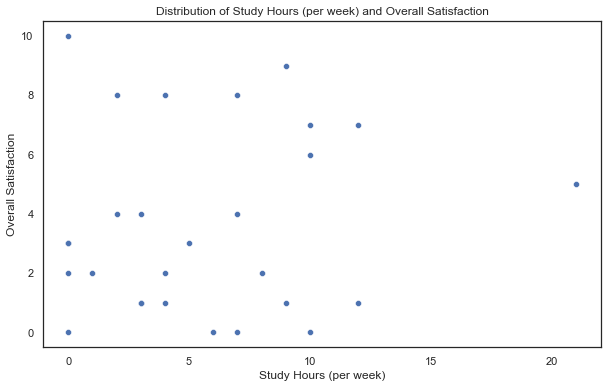

In [239]:
# Distribution of Study Hours (per week) and Overall Satisfaction
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.scatterplot(data=df, x='Study Hours (per week)', y='Overall Satisfaction', color=color)
plt.xlabel('Study Hours (per week)')
plt.ylabel('Overall Satisfaction')
plt.title('Distribution of Study Hours (per week) and Overall Satisfaction')
plt.show()

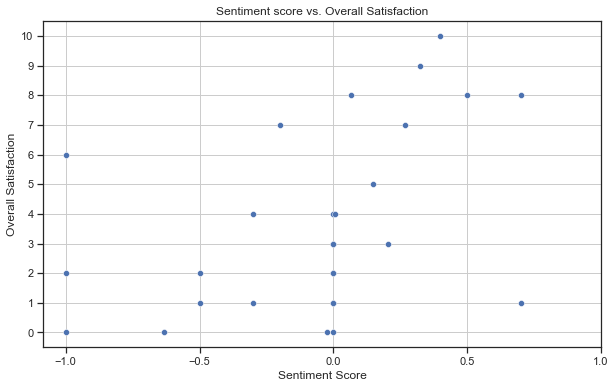

In [248]:
# Sentiment vs. Overall Satisfaction
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.scatterplot(x='Sentiment_Score', y='Overall Satisfaction', data=df, color=color)
plt.xlabel('Sentiment Score')
plt.ylabel('Overall Satisfaction')
plt.title('Sentiment score vs. Overall Satisfaction')
plt.xticks(np.arange(-1, 1.1, 0.5))
plt.yticks(np.arange(0, 11))
plt.grid(True)
plt.show()

<Figure size 720x432 with 0 Axes>

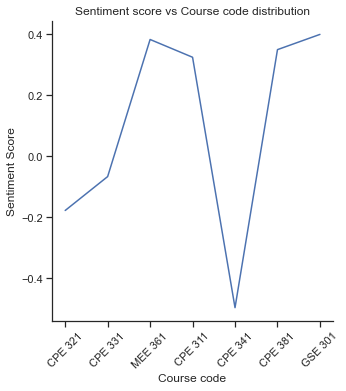

In [249]:
# Sentiment score Distribution by Course code
plt.figure(figsize=(10, 6))
color = sns.color_palette()[0]
sns.relplot(data=df, x='Course Code',y = 'Sentiment_Score', color=color, kind='line', ci=None)
plt.xlabel('Course code')
plt.ylabel('Sentiment Score')
plt.title('Sentiment score vs Course code distribution')
plt.xticks(rotation=45)
plt.show();

### Multivariate Exploration

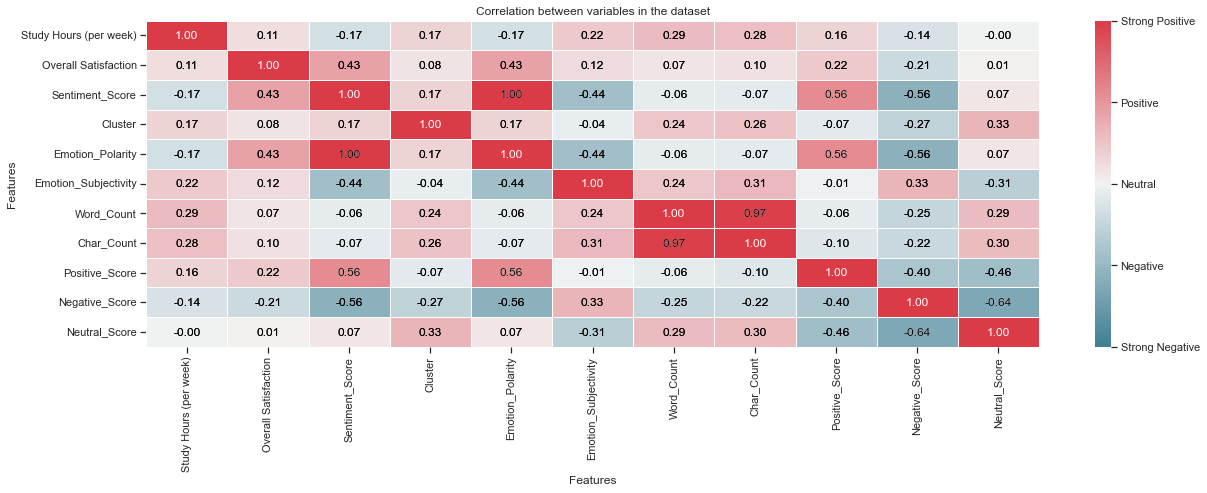

In [261]:
# correlation matrix of all variables in the data
correlation_matrix = df.corr()

plt.figure(figsize=[20, 6])
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation between variables in the dataset')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:
            text = '{:.2f}'.format(correlation_matrix.iloc[i, j])
            plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
colorbar.set_ticklabels(['Strong Negative', 'Negative', 'Neutral', 'Positive', 'Strong Positive'])

plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

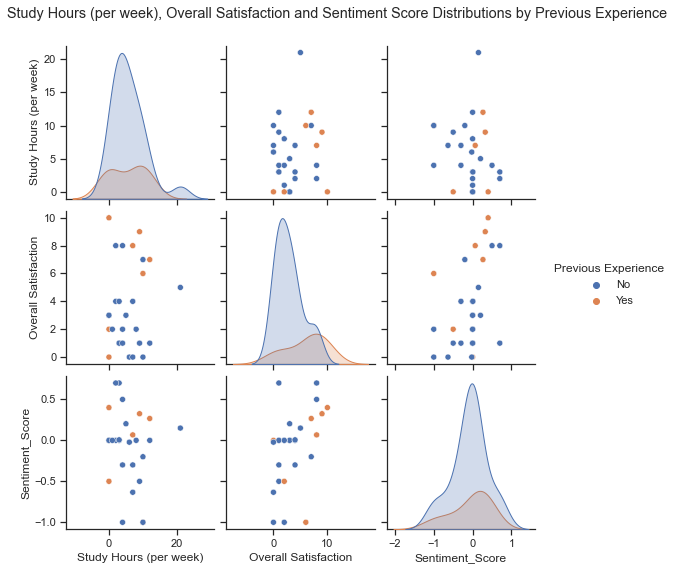

In [262]:
sns.set(style='ticks')
sns.pairplot(data=df, vars=['Study Hours (per week)', 'Overall Satisfaction', 'Sentiment_Score'], hue='Previous Experience', markers='o')
plt.suptitle('Study Hours (per week), Overall Satisfaction and Sentiment Score Distributions by Previous Experience', y=1.05)
plt.show();

## Feedback Analysis

In conclusion, the feedback analysis for the sentiment analysis project on student feedback in engineering education has provided valuable insights into the sentiments expressed by students and has offered recommendations for improvement. By analyzing the sentiment distribution, it is evident that the majority of feedback falls into the negative sentiment category, indicating poor satisfaction with the educational experience. However, it is important to note that there were also a significant number of positive and some neutral sentiments expressed. Additionally, it was observed that the majority of students had no previous experience.

The sentiment analysis revealed variations in sentiment across different courses, suggesting that certain courses may have specific strengths or areas for improvement. Among the courses, CPE 321 was identified as the most challenging, with the majority of negative sentiments expressed in relation to this course. Furthermore, a gender disparity was observed, as the negative sentiments were primarily expressed by male students, while no negative sentiments were reported by female students. It was also noted that courses categorized as moderate had the highest number of positive sentiments. Specifically, CPE 341 had the lowest sentiment score, while GSE 301 received the highest sentiment score. The Sentiment_Score exhibited a relatively high correlation with Overall Satisfaction, while it demonstrated a perfect correlation with Emotion_Polarity. Surprisingly, the study hours showed a low correlation with overall satisfaction, indicating the presence of other influential factors.

In addition to examining sentiment based on course and gender, the analysis explored other attributes to identify potential variations that could inform targeted interventions or support. By employing techniques such as topic modeling, key themes and topics discussed by students were uncovered, providing further context to their sentiments. These insights can guide curriculum development, faculty training, or resource allocation to address specific areas of concern or capitalize on identified strengths.

The sentiment analysis not only sheds light on the sentiments of students in the department but also provides actionable insights for improvement. This project serves as a foundation for ongoing feedback analysis and continuous enhancement of the educational experience based on student sentiments. By leveraging the power of sentiment analysis, the department can proactively address issues, tailor interventions, and strive for continuous improvement in engineering education. Moreover, the findings highlight the need for targeted interventions in specific courses, particularly CPE 321, where students expressed a higher number of negative sentiments. By addressing these concerns, the department can work towards providing a more fulfilling and satisfactory learning environment for the students. The analysis has uncovered the prevalence of negative sentiments, along with variations based on courses, gender, and other attributes. These findings can serve as a basis for informed decision-making, allowing the department to address concerns, capitalize on strengths, and continuously enhance the quality of education provided to students.